### Visualizing the learning of a neural network

#### prerequisite 
* RUN in Kaggle 
* Download [tiny-imagenet-challange](https://www.kaggle.com/competitions/tiny-imagenet/overview) data
* Install torchinfo ! pip install torchinfo 

 

In [4]:
! pip install torchinfo -q

In [5]:
#imports
import torch
import torchvision 
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot  as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import time
from tqdm import tqdm
import os
import cv2
from torchinfo import summary
from pathlib import Path
import numpy as np
from sklearn.decomposition import PCA

In [6]:
# load basic VGG-16 with random weights init 
vgg_16 = torchvision.models.vgg16()


In [7]:
summary(vgg_16, input_size=(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 2, 2]            --
│    └─Conv2d: 2-1                       [1, 64, 64, 64]           1,792
│    └─ReLU: 2-2                         [1, 64, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 64, 64, 64]           36,928
│    └─ReLU: 2-4                         [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-6                       [1, 128, 32, 32]          73,856
│    └─ReLU: 2-7                         [1, 128, 32, 32]          --
│    └─Conv2d: 2-8                       [1, 128, 32, 32]          147,584
│    └─ReLU: 2-9                         [1, 128, 32, 32]          --
│    └─MaxPool2d: 2-10                   [1, 128, 16, 16]          --
│    └─Conv2d: 2-11                      [1, 256, 16, 16]          29

In [ ]:
# custome dataset and dataloaders 
train_ds_path = "../input/tiny-imagenet-challenge/TinyImageNet/train"
torch.manual_seed(0)
tiny_image_net_dataset = datasets.ImageFolder(train_ds_path, 
                                              transform = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                                                             ]))
tiny_image_net_dataloader = DataLoader(tiny_image_net_dataset, batch_size=512, shuffle=True)



In [ ]:
image, label =  next(iter(tiny_image_net_dataloader))
i = 0
plt.title(f"{label[i]}")
plt.imshow(image[i].permute(1,2,0))
  

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
vgg_16 = vgg_16.to(device)

crt_CEL = nn.CrossEntropyLoss()

optm_vgg_16 = optim.SGD(vgg_16.parameters(), lr=0.001, momentum=0.9)

sch_cycl_lr = lr_scheduler.CyclicLR(optm_vgg_16,base_lr=0.001,max_lr=0.01, gamma=0.1)

In [8]:
# visualizing these paramenters 
parameters = ["features.0.weight","features.2.weight","features.5.weight","features.7.weight","features.10.weight",             
                "features.12.weight","features.14.weight","features.17.weight","features.19.weight","features.21.weight",
                "features.24.weight","features.26.weight", "features.28.weight"]

In [ ]:
def train(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_acc = 0.0
    model_dir = 'model/vgg16/'
#     os.makedirs(model_dir)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
      
        running_loss = 0.0
        running_corrects = 0

        batch = 0 
        for i ,(inputs, labels) in enumerate (tqdm(tiny_image_net_dataloader)):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            scheduler.step()



        epoch_loss = running_loss / len(tiny_image_net_dataset)
        epoch_acc = running_corrects.double() / len(tiny_image_net_dataset)



        weights = dict()    
        for param in parameters :
                weights[param] = model.state_dict()[param]  

        torch.save({"Model_params":weights ,
                   "EPOCH":epoch,
                   "Loss":epoch_loss},f"{model_dir}/vgg16_{epoch}.pt")
        print(f' Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


       
           
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    return model

In [ ]:
train(model=vgg_16, criterion=crt_CEL, optimizer=optm_vgg_16, scheduler=sch_cycl_lr, num_epochs=64)

#### Visualaization 

Linear summation 

In [ ]:
# create  images from weights file 

for wts_file in sorted(os.listdir("model/vgg16"), key = lambda x : int(x[6:-3])):
    vgg16_wts = torch.load(f"model/vgg16/{wts_file}")["Model_params"]
#     print(wts_file)
    for parameter in parameters :
        layer_i_sum = torch.sum(vgg16_wts[parameter], dim=1) 
        upscale = torch.nn.functional.interpolate(torch.unsqueeze((layer_i_sum ), dim=1),
                                                  size=(128,128), mode='nearest').cpu()
        for i in range(len(upscale)) :
            p = f"model/vgg16_imgs/{parameter}/{i}/"
            Path(p).mkdir(parents=True, exist_ok=True )
#             cv2.imwrite(f"{p}/{str(wts_file[6:-3]).zfill(2)}.png",
#                         ((upscale[i]+1)*127).permute(1,2,0).numpy())
            plt.imshow(((upscale[i]+1)*127).permute(1,2,0).numpy())
            

In [ ]:
# make GIF
import glob
from PIL import Image
def make_gif(frame_folder, name):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*")]
    frame_one = frames[0]
    frame_one.save(name, format="GIF", append_images=frames,
               save_all=True, duration=512, loop=1)
    
for ft in os.listdir("model/vgg16_imgs/")   :
    for layer in os.listdir(f"model/vgg16_imgs/{ft}") :
            make_gif(f"model/vgg16_imgs/{ft}/{layer}/", f"model/gif/{ft.replace('.','')}_{layer}.gif")    
          

In [125]:
# combine all kernels into one image linear summation

from pathlib import Path
upsize = 27
#width [8,16,16,32] 
for wts_file in sorted(os.listdir("model/vgg16"), key = lambda x : int(x[6:-3])):
    vgg16_wts = torch.load(f"model/vgg16/{wts_file}", map_location=device)["Model_params"]
#     print(wts_file)
    for parameter in parameters :
        layer_i_sum = torch.sum(vgg16_wts[parameter], dim=1) 
        upscale = torch.nn.functional.interpolate(torch.unsqueeze((layer_i_sum ), dim=1),
                                                  size=(upsize,upsize), mode='nearest')
          
        if upscale.shape[0] == 64 :
            size = (8*upsize, 8*upsize)
            width = 8
        if upscale.shape[0] == 128 :
            size = (8*upsize,16*upsize)
            width = 16
        if upscale.shape[0] == 256 :
            size = (16*upsize, 16*upsize)
            width = 16
        if upscale.shape[0] == 512 :
            size = (16*upsize, 32*upsize)
            width = 32
                    
        all_params = torch.zeros(size, device=device)
        
        i, j = 0,0  # start index
        for kernel in upscale :
            
           
            all_params[j:j+upsize,i:i+upsize] = kernel[0]
            
            if i == (width-1)*upsize :
                i = 0
                j += upsize
                
            else :
                i += upsize
                    
#         plt.imshow(all_params)
        p = f"kernels/{parameter.replace('.','')}/"
        Path(p).mkdir(parents=True, exist_ok=True )
        cv2.imwrite(f"{p}/{str(wts_file[6:-3]).zfill(2)}.png", 
                        cv2.putText(((all_params + 1)*127).cpu().numpy(),
                                                    f'{wts_file[6:-3]}',
                                                    (0, size[0]-10), cv2.FONT_HERSHEY_DUPLEX,
                                                    1.0,(254),1))
       

In [128]:
# make gif 
import glob
from PIL import Image
def make_gif(frame_folder, name):
    frames = [Image.open(f"{frame_folder}/{image}") for image in sorted(os.listdir(f"{frame_folder}"), key=lambda x: x[:-4])]
    frame_one = frames[0]
    frame_one.save(name, format="GIF", append_images=frames,
               save_all=True, duration=255, loop=1)
    
for ft in os.listdir("kernels/")   :
    make_gif(f"kernels/{ft}",f"gif/{ft}.gif")
           

PCA 

project n features of weights file to 3d , for visualization

In [17]:


def fun_red(param, upsize, pca) :
    
    p = torch.empty((1,3,3,3))
    oc,ic = param.shape[:2]
    prm_reshaped = torch.reshape(param, (oc,9,ic))
    for prm in prm_reshaped :
        projection = pca.fit_transform(prm).reshape(1,3,3,3)
        p = torch.cat((p, torch.from_numpy(projection)), dim=0)
      
    upscale = torch.nn.functional.interpolate((p + 1)*127,
                                          size = (upsize, upsize),mode='nearest').cpu()
    return upscale[1:]



In [68]:

# combine all kernels into one image 
from pathlib import Path
def dim_reduction(rdc_fun,save_dir) :
    
    upsize = 18
    
    for wts_file in sorted(os.listdir("model/vgg16"), key = lambda x : int(x[6:-3])):
        print(wts_file)
        vgg16_wts = torch.load(f"model/vgg16/{wts_file}", map_location=device)["Model_params"]
        for parameter in parameters :
#             print(vgg16_wts[parameter].shape)
            upscale = rdc_fun(vgg16_wts[parameter], upsize, PCA(3)) 
#             print(upscale.shape)
            if upscale.shape[0] == 64 :
                size = (3, 8*upsize, 8*upsize)
                width = 8
            if upscale.shape[0] == 128 :
                size = (3, 8*upsize,16*upsize)
                width = 16
            if upscale.shape[0] == 256 :
                size = (3, 16*upsize, 16*upsize)
                width = 16
            if upscale.shape[0] == 512 :
                size = (3, 16*upsize, 32*upsize)
                width = 32

            all_params = torch.zeros(size, device=device)

            i, j = 0,0  # start index
            for kernel in upscale :
                all_params[:, j:j+upsize,i:i+upsize] = kernel
                if i == (width-1)*upsize :
                    i = 0
                    j += upsize
                else :
                    i += upsize

            p = f"{save_dir}/{parameter.replace('.','')}/"
            Path(p).mkdir(parents=True, exist_ok=True)
            cv2.imwrite(f"{p}/{str(wts_file[6:-3]).zfill(2)}.png",
                        all_params.permute(1,2,0).cpu().numpy())
                        
                

In [ ]:
for ft_folder in os.listdir('gif') :
    if not ft_folder.endswith('.gif') : 
        for img in sorted(os.listdir(f"gif/{ft_folder}"), key= lambda x : int(x[:-4])):
            cv2.imwrite(f"gif/{ft_folder}/{img}", cv2.putText(cv2.imread(f"gif/{ft_folder}/{img}"),
                           f'{img[:-4]}',(10,50), 
                            cv2.FONT_HERSHEY_DUPLEX,0.5,(254),1))
    

In [74]:
import glob
from PIL import Image
def make_gif(frame_folder, name):
    frames = [Image.open(f"{frame_folder}/{image}") for image in sorted(os.listdir(f"{frame_folder}"), key=lambda x: x[:-4])]
    frame_one = frames[0]
    frame_one.save(name, format="GIF", append_images=frames,
               save_all=True, duration=255, loop=1)
    
for ft in os.listdir("gif/")   :
    make_gif(f"gif/{ft}",f"gif/{ft}.gif")

output from convolutions  

In [2]:
vgg_16 = torchvision.models.vgg16(pretrained=False).eval()


In [5]:
cat_img = cv2.imread("/kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4052.jpg")
cat_img = torch.from_numpy(cat_img)
batch_img = torch.unsqueeze(cat_img.permute(2,0,1), dim=0).float()
batch_img.shape

torch.Size([1, 3, 307, 352])

In [6]:
with torch.no_grad() :
    f0 = vgg_16.features[0](batch_img)
    f2 = vgg_16.features[2](vgg_16.features[1](f0))
    f5 = vgg_16.features[5](vgg_16.features[4](vgg_16.features[2](f2)))
    f7 = vgg_16.features[7](vgg_16.features[6](f5))
    

In [12]:
def plot_conv_outputs(feature, fname):
    
    fs = feature.shape[0]
    fig = plt.figure(figsize=(fs,fs))
    rows = fs//12
    columns = fs//rows
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(feature[i-1])
    plt.show()
    if fname :
        fig.savefig(fname,)

# plot_conv_outputs(f7[0], fname = 'f7.png')    

In [25]:
def pca_image(t, pca): 
    """ t - dim 3"""
    c,w,h = t.shape
    t = torch.reshape(t, (c, w*h))
    t = pca.fit_transform(t.permute(1,0))
    t = t.reshape((w,h,3))
    
    return t 


color_img_f0 = pca_image(f0[0], PCA(3))
color_img_f2 = pca_image(f2[0], PCA(3))
color_img_f5 = pca_image(f5[0], PCA(3))
color_img_f7 = pca_image(f7[0], PCA(3))


print(color_img_f0.shape,color_img_f2.shape,color_img_f5.shape,color_img_f7.shape) 

(307, 352, 3) (307, 352, 3) (153, 176, 3) (153, 176, 3)


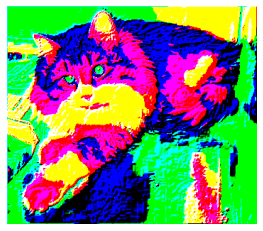

In [36]:
plt.axis("off")
plt.imshow(color_img_f0)
plt.savefig("clr_img_f0.png")

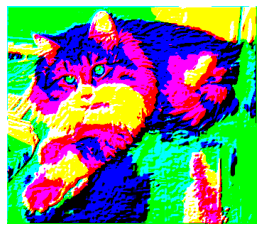

In [41]:
plt.axis("off")
plt.imshow(color_img_f2)
plt.savefig("clr_img_f2.png")

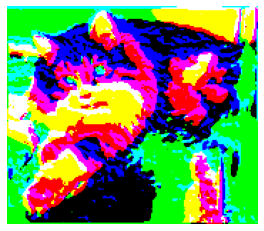

In [42]:
plt.axis("off")
plt.imshow(color_img_f5)
plt.savefig("clr_img_f5.png")


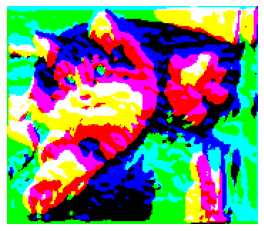

In [43]:
plt.axis("off")
plt.imshow(color_img_f7)
plt.savefig("clr_img_f7.png")